<p style="color: #FFBB00; font-weight: bold; text-align: center; font-family: sans-serif; font-size: 2.3em;\">Анализ ВВП Республики Гана</p>
<p style="color: #318CE7; font-weight: bold; text-align: center; font-size: 1.9em;\">Практическая работа</p>

---------------------

In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams["figure.facecolor"] = '#D4F3EF'
plt.rcParams["font.family"] = 'sans-serif'

In [2]:
# Информация о признаках, пропусках и дубликатах
def inf(data, raw=0):
    display(data.head(raw)) if raw!=0 else 0
    raw = data.shape[0]
    col = data.shape[1]
    duble = data.duplicated().sum()
    nan_all = data.isnull().sum().sum()
    if nan_all == 0:
        none_nan = "NaN not detected."
    else:
        none_nan = data.isnull().sum().to_frame(name='NaN').query('NaN>0')
    print(f"Строки: {raw} \nПризнаки: {col} \nДубликаты: {duble} \nПропуски: {none_nan}")

# Тест Дики ─ Фуллера
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['Statistics:','p-value:', 'Lags:', 'Observations:', 'Critical values:']
    for value,label in zip(result,labels):
        print(label+' '+str(value))
    if result[1] <= 0.05:
        print("\nПолученные данные показывают, что нулевую гипотезу (Ho) можно отвергнуть.", "\nРяд стационарен.")
    else:
        print("\nПолученные данные не позволяют отвергнуть нулевую гипотезу.", "\nРяд нестационарен.")
    # return result[1]

# Дифференцирование и определение d
def differ(data):
    def print_data():
        print("d =", n)
        print("Statistics =", adfuller(data)[0])
        print("p-value =", adfuller(data)[1])
        print("Critical values =", adfuller(data)[4], '\n')
    n = 0
    while adfuller(data)[1] > 0.05:
        print_data()
        data = data.diff()[1:]
        n += 1
    print_data()
    return n, data

# Графики Autocorrelation и Partial Autocorrelation
def plot_acf_pacf(series, n_lags=20, width=10, hight=5):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, hight))
    sgt.plot_acf(series, lags=n_lags, ax=ax1)
    sgt.plot_pacf(series, method='ywm', lags=n_lags, ax=ax2)
    plt.show();

<p style="color: #318CE7; font-weight: bold; text-align: center; font-size: 1.9em;\">1. Статистические модели прогнозирования</p>

-----------------------------------
<p style="color: darkgreen; font-size: 2.0em;\">Задание 1.1</p>
  
Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

In [3]:
# Чтение исходного файла
df = pd.read_csv("data/ghana_gdp.zip", parse_dates=["year"], 
                 index_col = ["year"])
inf(df)
df.head()

Строки: 62 
Признаки: 1 
Дубликаты: 0 
Пропуски: NaN not detected.


,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


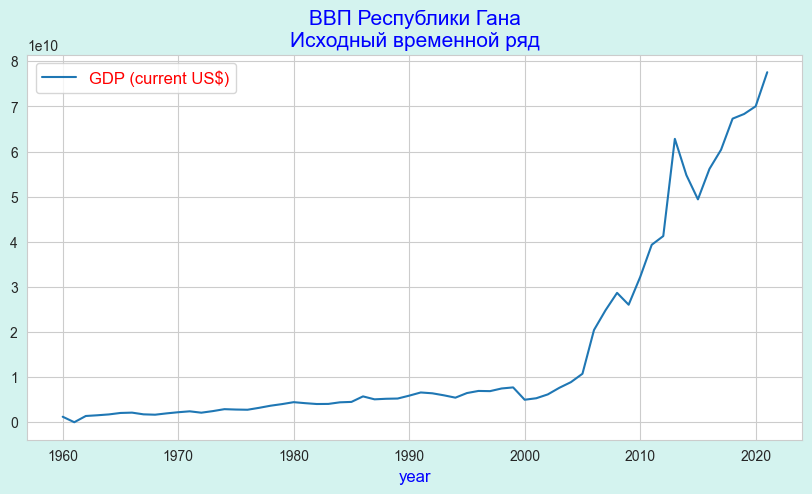

In [4]:
# Визуализация исходного временного ряда
fig, ax = plt.subplots(figsize=(10, 5)) #, facecolor='#D4F3EF')
ax.plot(df)
ax.set_title('ВВП Республики Гана\nИсходный временной ряд', fontsize=15, color='blue')
ax.legend(labels=["GDP (current US$)"], labelcolor='red', fontsize=12)
ax.set_xlabel('year', fontsize=12, color='blue')
plt.show();

In [5]:
# делаем train-выборку
train_df = df.loc[:"2018-01-01"]
# для test-выборки используем последние три года
test_df = df.loc["2019-01-01":]
print("TRAIN:", train_df.shape, "\nTEST:", test_df.shape)

TRAIN: (59, 1) 
TEST: (3, 1)


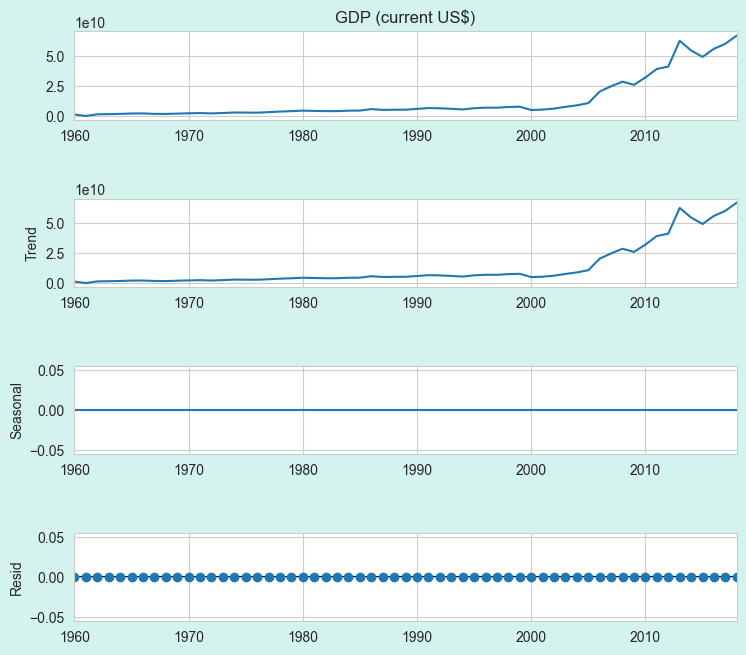

In [6]:
# Визуализация исходного ряда TRAIN, декомпозиция
result = seasonal_decompose(train_df['GDP (current US$)'], model='additive')
fig = result.plot()
fig.set_size_inches(7.77, 7)
plt.show();

Присутствует явный тренд, сезонность не наблюдается.  

<p style="color: darkgreen; font-size: 2.0em;\">Задание 1.2</p>
  
Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.  
  
Пример: `train_df.spx.rolling(window=2).mean()`  
  
Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.  

`Построение моделей со скользящим средним.`

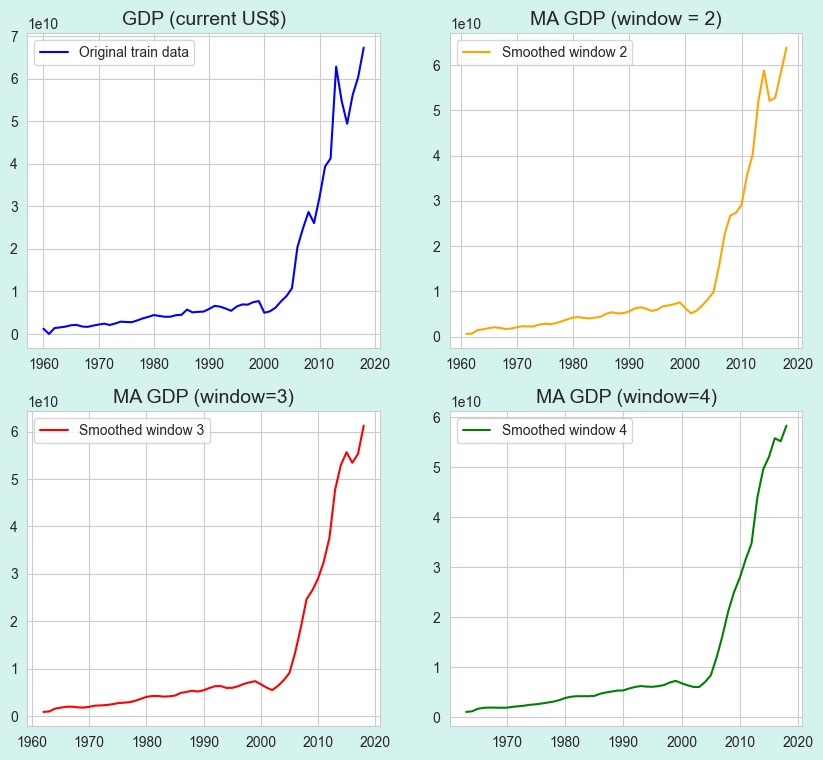

In [7]:
# визуализация временного ряда со скользящим средним
fig, ax = plt.subplots(2, 2, figsize=(10, 9))

ax[0, 0].plot(train_df['GDP (current US$)'], color = "blue", 
              label = "Original train data")
ax[0, 0].set_title("GDP (current US$)", size = 14)
ax[0, 0].legend()

ax[0, 1].plot(train_df['GDP (current US$)'].rolling(2).mean(), 
              color = "orange", label = "Smoothed window 2")
ax[0, 1].set_title("MA GDP (window = 2)", size = 14)
ax[0, 1].legend()

ax[1, 0].plot(train_df['GDP (current US$)'].rolling(3).mean(), 
              color = "red", label = "Smoothed window 3")
ax[1, 0].set_title("MA GDP (window=3)", size = 14)
ax[1, 0].legend()

ax[1, 1].plot(train_df['GDP (current US$)'].rolling(4).mean(), 
              color = "green", label = "Smoothed window 4")
ax[1, 1].set_title("MA GDP (window=4)", size = 14)
ax[1, 1].legend();

Скользящее среднее с окном два года (жёлтая кривая) неэффективно борется с выбросами.  
Скользящее среднее с окном четыре года (зелёная кривая) слишком эффективно, возможны потери в данных  
Лучший вариант ─ скользящее среднее с окном три года.

<p style="color: darkgreen; font-size: 2.0em;\">Задание 1.3</p>
  
С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели *ARMA/ARIMA*.  
  
>**Примечание.**  
Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым.  
Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим  
параметром ***d*** для модели *ARIMA*.  
  
Параметры ***p*** и ***q*** выберите по коррелограммам **ACF** и **PACF**.  
  
>**Примечание.**  
Помните, что параметры ***p*** и ***q*** для *ARMA/ARIMA* определяются из коррелограмм стационарного ряда.  
То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для  
разностей того порядка, которые являются стационарными.  
  
Постройте модель *ARMA/ARIMA* для прогнозирования поведения временного ряда.  
Также постройте несколько моделей с параметрами, ближайшими к найденным ***p*** и ***q***, и сравните коэффициент *AIC* (или подберите наилучшие параметры с помощью пакета `pmdarima`, как в скринкасте).

In [8]:
# Тест Дики ─ Фуллера
adfuller_test(train_df["GDP (current US$)"])

Statistics: 0.6529066974885367
p-value: 0.9888496277665573
Lags: 10
Observations: 48
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Полученные данные не позволяют отвергнуть нулевую гипотезу. 
Ряд нестационарен.


Ряд нестационарен. Необходимо провести дифференциацию ряда.

In [9]:
# Дифференциация и определение порядка DS-ряда
d, df_diff = differ(train_df['GDP (current US$)'])
print(f"При d = {d} ряд становится стационарным\n")

d = 0
Statistics = 0.6529066974885367
p-value = 0.9888496277665573
Critical values = {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777} 

d = 1
Statistics = -1.670248303832079
p-value = 0.4465029329713883
Critical values = {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616} 

d = 2
Statistics = -2.640869056128483
p-value = 0.08484116917837797
Critical values = {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153} 

d = 3
Statistics = -4.779623784828528
p-value = 5.9483276402250296e-05
Critical values = {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777} 

При d = 3 ряд становится стационарным



Интегрированный ряд третьего порядка является стационарным.  
При порядке дифференцирования ***d = 3*** ряд становится стационарным.

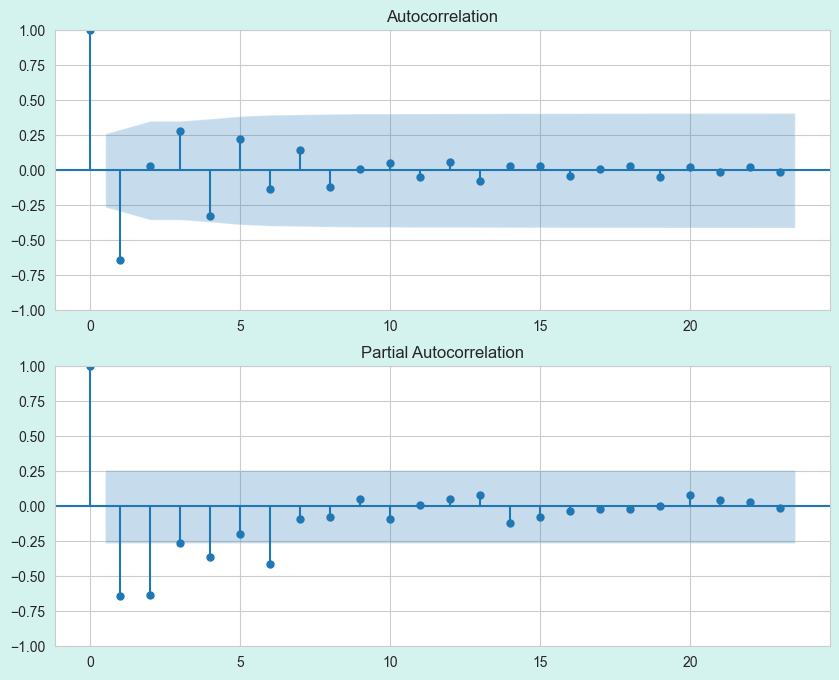

Statistics: -4.779623784828528
p-value: 5.9483276402250296e-05
Lags: 7
Observations: 48
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Полученные данные показывают, что нулевую гипотезу (Ho) можно отвергнуть. 
Ряд стационарен.


In [10]:
# Диаграммы ACF и PACF стационарного ряда
plot_acf_pacf(df_diff, 23, 10, 8)
adfuller_test(df_diff)

Определяем параметры ***p*** и ***q*** из коррелограмм выше. Выбираем:  
***p = 2***  
***d = 3***  
***q = 1***  
  
Помио этого, проведём поиск наилуших параметров ***p, q*** с помощью пакета `pmdarima`. Значение ***d*** нам известено ─ ***3***, поэтому явно указываем его в установках параметров. Значение ***m*** устанваливаем в ***1***, так как у нас сезонности нет (годичная).

In [11]:
# Подбор наилучших параметров
smodel = pm.auto_arima(
    train_df, 
    start_p=1, max_p=10, 
    start_q=1, max_q=10, 
    d=d, 
    test='adf',
    m=1,
    start_P=0, 
    seasonal=False,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
    )

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.05 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.525 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sun, 26 Feb 2023   AIC                           2659.231
Time:                        15:53:32   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.72e+56. Standard errors may be unstable.
"""

Найденные наилучшие параметры с помощью пакета pmdarima (2, 3, 1) совпадают с теми, которые были определены "вручную" ─ (2, 3, 1).  

<p style="color: darkgreen; font-size: 2.0em;\">Задание 1.4</p>  
  
Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [12]:
# Построение модели с наилучшими параметрами
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), 
                    order = (2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sun, 26 Feb 2023   AIC                           2659.231
Time:                        15:53:32   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.72e+56. Standard errors may be unstable.
"""

In [13]:
# Предсказание для тестовой выборки
pred_df = pd.DataFrame(index = df.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[0], 
                                                 end = test_df.index[-1])

pred_df['GDP (current US$)'] = df['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05)

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

<p style="color: darkgreen; font-size: 2.0em;\">Задание 1.5</p>
  
Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

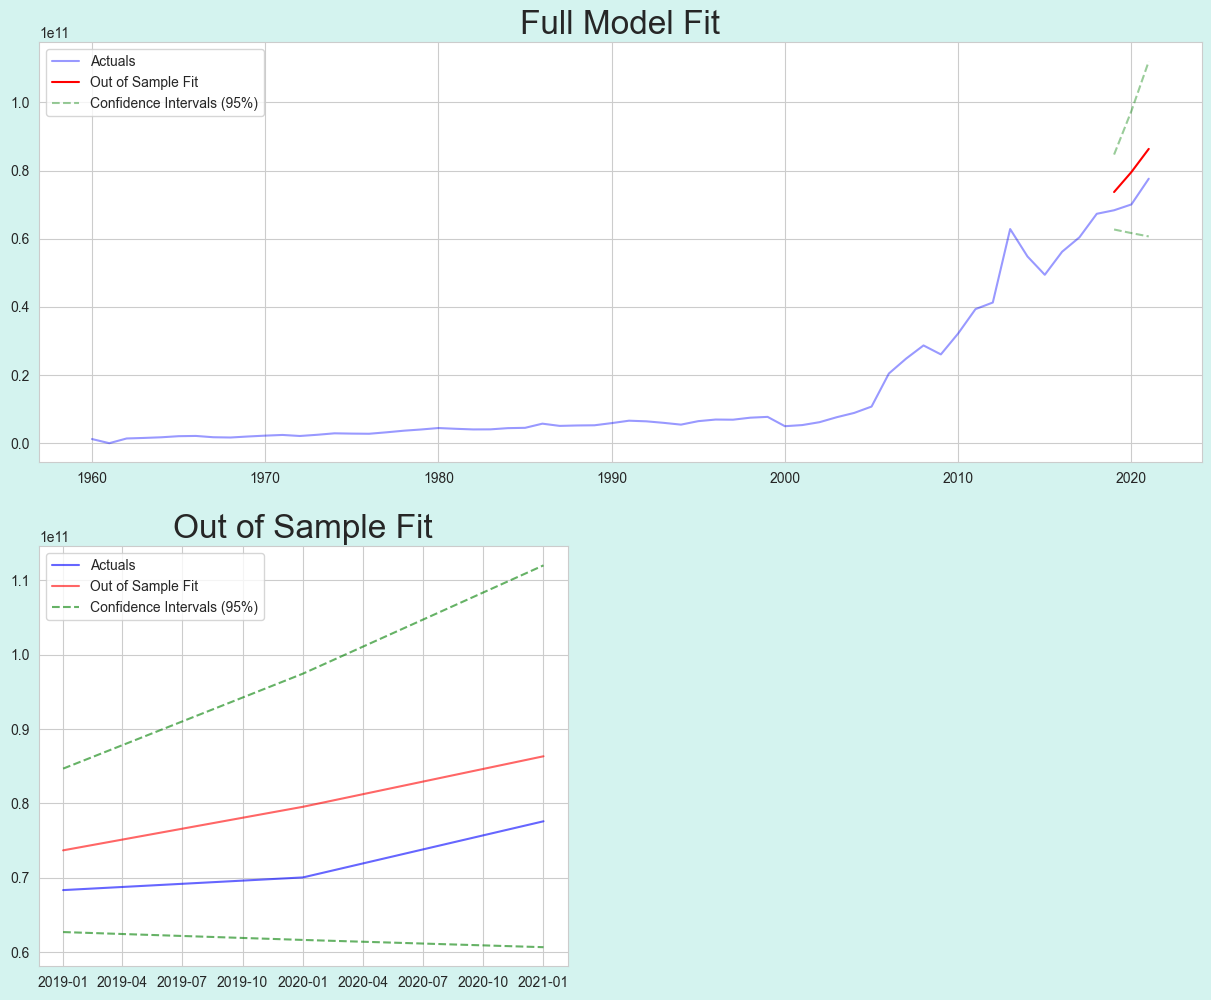

In [14]:
plt.rcParams["figure.figsize"] = 15, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df['GDP (current US$)'], color = "blue", 
         label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], 
         color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], 
         color = "green", linestyle = "--", 
         label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], 
         color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]['GDP (current US$)'], 
         color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], 
         color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], 
         color = "green", linestyle = "--", 
         label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], 
         color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show();

<p style="color: darkgreen; font-size: 2.0em;\">Задание 1.6</p>
Сделайте выводы.  
  
Был дан датафрейм ВВП Республики Гана. В значении признака 1961-01-01 присутствует 0 с которым не производилось никаких действий.  
После разделения на подвыборки Train и test, тест Дика ─ Фуллера показал, что временной ряд Train нестационарен.  
Взятие разностей определило порядок интегрированного ряда, он равен ***3***.  
Модель уловила тренд, но предсказание завышено, прогноз фондового индекса входит в 95%-ый доверительный интервал.

<p style="color: #318CE7; font-weight: bold; text-align: center; font-size: 1.9em;\">2. Интерполяция и сэмплирование</p>

-----------------------------------------
<p style="color: darkgreen; font-size: 2.0em;\">Задание 2.1</p>
  
Проверьте данные на наличие пропущенных дат. Помимо визуального способа это можно сделать с помощью метода *DataFrame.asfreq()*, передав в него параметр частоты, например, 'd' ─ день, 'm' ─ месяц.

In [15]:
# Проверка данных на пропуски в датах  
df = pd.read_csv('data/ghana_gdp.zip', parse_dates=["year"], index_col = ["year"])

display(df.head())
if df.shape == df.asfreq(freq='AS').shape:
    print("Пропущенных дат нет")
else:
    print("Имеются пропущенные даты")

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Пропущенных дат нет


<p style="color: darkgreen; font-size: 2.0em;\">Задание 2.2</p>  
  
Проверьте данные на наличие пропущенных значений.

In [16]:
# Проверка df
inf(df)

Строки: 62 
Признаки: 1 
Дубликаты: 0 
Пропуски: NaN not detected.


<p style="color: darkgreen; font-size: 2.0em;\">Задание 2.3</p>  
  
Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на *NaN*. 

In [17]:
# Замена найденных нулей на NaN
df.loc[df["GDP (current US$)"].eq(0), "GDP (current US$)"] = np.nan
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,NaN
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<p style="color: darkgreen; font-size: 2.0em;\">Задание 2.4</p>
  
Заполните пропуски, выполнив интерполяцию с использованием метода *.interpolate()*

In [18]:
# Выполнение интерполяции  
InterPol = pd.DataFrame(df.interpolate(method='linear'), 
                        columns = ["GDP (current US$)"])
InterPol.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<p style="color: darkgreen; font-size: 2.0em;\">Задание 2.5</p>
  
Проверьте полученный ряд на стационарность, определите параметры модели *(ARIMA/ARMA)* и запустите модель.

In [19]:
# делаем train-выборку
train_df = InterPol.loc[:"2018-01-01"]
# для test-выборки используем последние три года
test_df = InterPol.loc["2019-01-01":]
print("TRAIN:", train_df.shape, "\nTEST:", test_df.shape)

TRAIN: (59, 1) 
TEST: (3, 1)


In [20]:
# Проверка на стационарность
adfuller_test(train_df['GDP (current US$)'])

Statistics: 0.8030073326980115
p-value: 0.9916845572455877
Lags: 10
Observations: 48
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Полученные данные не позволяют отвергнуть нулевую гипотезу. 
Ряд нестационарен.


Поскольку ряд нестационарен, то проводим дифференцирование и определяем параметр ***d*** ─ порядок дифференцирования.

In [21]:
# Дифференциация и определение порядка DS-ряда
d, df_diff = differ(train_df['GDP (current US$)'])
print(f"При d = {d} ряд становится стационарным\n")

d = 0
Statistics = 0.8030073326980115
p-value = 0.9916845572455877
Critical values = {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777} 

d = 1
Statistics = -1.8255652246436056
p-value = 0.3678451527656314
Critical values = {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616} 

d = 2
Statistics = -2.634634746007848
p-value = 0.08604813722197563
Critical values = {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153} 

d = 3
Statistics = -4.825603687304028
p-value = 4.8573180767997966e-05
Critical values = {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777} 

При d = 3 ряд становится стационарным



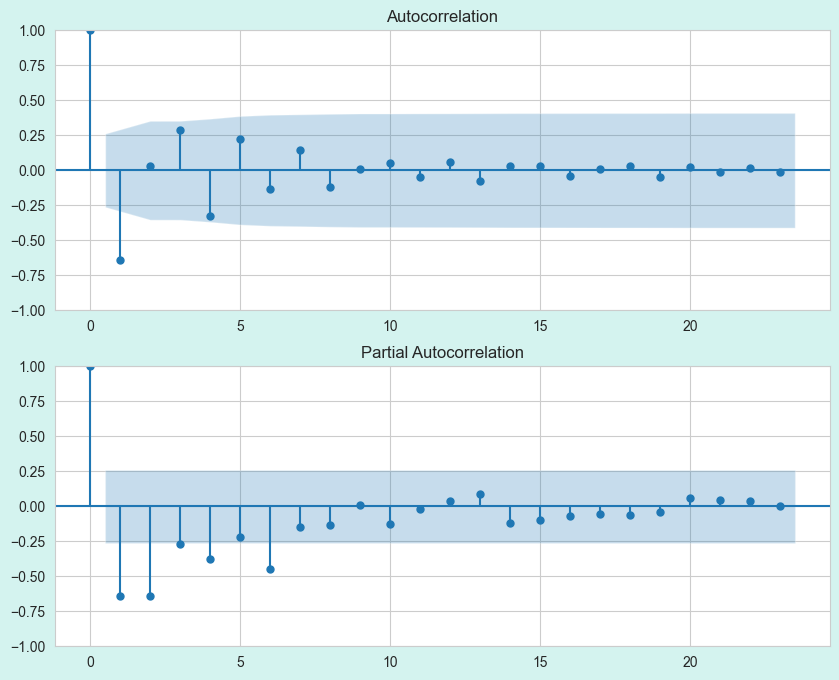

Statistics: -4.825603687304028
p-value: 4.8573180767997966e-05
Lags: 7
Observations: 48
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}

Полученные данные показывают, что нулевую гипотезу (Ho) можно отвергнуть. 
Ряд стационарен.


In [22]:
# Диаграммы ACF и PACF стационарного ряда
plot_acf_pacf(df_diff, 23, 10, 8)
adfuller_test(df_diff)

По коррелограммам определяем параметры:  
  
***p = 2***  
***d = 3***  
***q = 1***  
  
Также видно, что диаграммы с интерполяцией практически не отличаются от диаграмм без интерполяции. Полагаю, что это вызвано тем, что с нулём было только одно значение и в той области кривой, где тренд был выражен весьма слабо.  
  
Определяем наилучшие параметры с помощью `auto_arima`.

In [23]:
# Подбор наилучших параметров
smodel = pm.auto_arima(
    train_df, 
    start_p=1, max_p=7, 
    start_q=1, max_q=7, 
    d=3, 
    test='adf',
    m=1,
    start_P=0, 
    seasonal=False,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
    )

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.03 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.05 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.482 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sun, 26 Feb 2023   AIC                           2659.226
Time:                        15:53:34   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.96e+55. Standard errors may be unstable.
"""

Полученные параметры ***p, q*** совпадают с параметрами, определёнными "вручную". Строим модель.

In [24]:
# Построение модели с наилучшими параметрами
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), 
                    order = (2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sun, 26 Feb 2023   AIC                           2659.226
Time:                        15:53:34   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.96e+55. Standard errors may be unstable.
"""

<p style="color: darkgreen; font-size: 2.0em;\">Задание 2.6</p>
  
Изменился ли *AIC* критерий построенной модели по сравнению с моделью на неинтерполированных данных?  
Сделайте вывод.  
  
В исходных данных нулевое значение 1961-01-01 было интерполировано.  
*AIC* на неинтерполированной модели равен 2659.231  
*AIC* на интерполированной модели равен 2659.226  
Критерий *AIC* построенной модели по сравнению с моделью на неинтерполированных данных изменился.  
Стал лучше на 0.005.  Интерполяция, восстановив промежуточное значение, микроскопически улучшила прогноз.  
И, поскольку было интерполировано только одно значение и в той области кривой тренда, где он мало изменяется, то небольшая величина изменения *AIC* вполне ожидаема.

<p style="color: #318CE7; font-weight: bold; text-align: center; font-size: 1.9em;\">3. Модели прогнозирования гетероскедастичности. <br>Валидация временных рядов</p>  
  
---------------------------------------------------------------
<p style="color: darkgreen; font-size: 2.0em;\">Задание 3.1</p>
  
Посчитайте волатильность для вашего временного ряда.

,GDP (current US$),GDP_vol
year,,
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
1965-01-01,2.053221e+09,18.608414
...,...,...
2017-01-01,6.040638e+10,7.551317
2018-01-01,6.729928e+10,11.410877
2019-01-01,6.833754e+10,1.542746


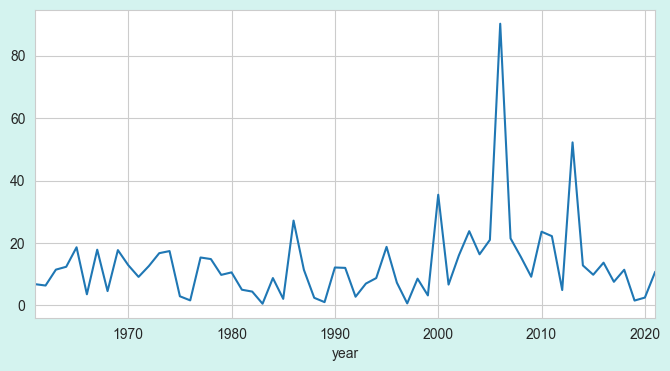

In [25]:
# Волатильность временного ряда
plt.rcParams["figure.figsize"] = 8, 4
InterPol["GDP_vol"] = InterPol['GDP (current US$)'].pct_change(1).mul(100).abs()
InterPol.dropna(inplace=True)
display(InterPol)
InterPol['GDP_vol'].plot();

<p style="color: darkgreen; font-size: 2.0em;\">Задание 3.2</p>

Используйте *GARCH*-модель для предсказания волатильности.

In [26]:
train_df, test_df = InterPol.loc[:"2018-01-01"], InterPol.loc["2019-01-01":]

# Проверка ряда на стационарность
adfuller_test(train_df['GDP_vol'][1:])

Statistics: -6.694716614110238
p-value: 4.026660991193168e-09
Lags: 0
Observations: 56
Critical values: {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}

Полученные данные показывают, что нулевую гипотезу (Ho) можно отвергнуть. 
Ряд стационарен.


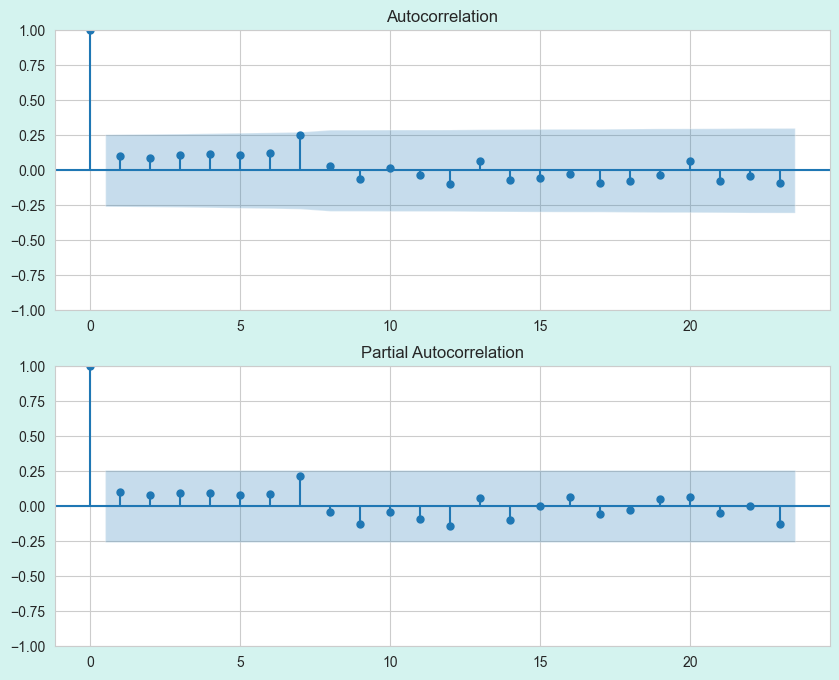

In [27]:
# Диаграммы ACF и PACF стационарного ряда
plot_acf_pacf(train_df['GDP_vol'], 23, 10, 8)

Выбираем ***p = 1***, ***q = 1***

In [28]:
garch_df = pd.DataFrame(InterPol['GDP_vol'].loc[InterPol.index]) 
display(garch_df)


,GDP_vol
year,
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
1965-01-01,18.608414
...,...
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746


In [29]:
# Обучаем модель и делаем прогноз
from arch import arch_model
model = arch_model(garch_df['GDP_vol'], p = 1, q = 1, vol = "GARCH")
model_results = model.fit(last_obs = train_df.index[-1], update_freq = 5)

predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast()\
    .residual_variance.loc[test_df.index]

Iteration:      5,   Func. Count:     27,   Neg. LLF: 247.95420470455127
Iteration:     10,   Func. Count:     57,   Neg. LLF: 237.6112987195586
Iteration:     15,   Func. Count:     85,   Neg. LLF: 223.50475325756761
Iteration:     20,   Func. Count:    110,   Neg. LLF: 222.86320785503517
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.86320785503517
            Iterations: 20
            Function evaluations: 110
            Gradient evaluations: 20


<p style="color: darkgreen; font-size: 2.0em;\">Задание 3.3</p>
  
Используйте линейную регрессию для получения прогноза.

In [30]:
X_train = pd.DataFrame(range(InterPol['GDP_vol']\
    .shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(InterPol['GDP_vol']\
    .shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['GDP_vol'].fillna(0)
y_test = test_df['GDP_vol'].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

<p style="color: darkgreen; font-size: 2.0em;\">Задание 3.4</p>
  
Визуализируйте полученное предсказание вместе с фактическим значением.

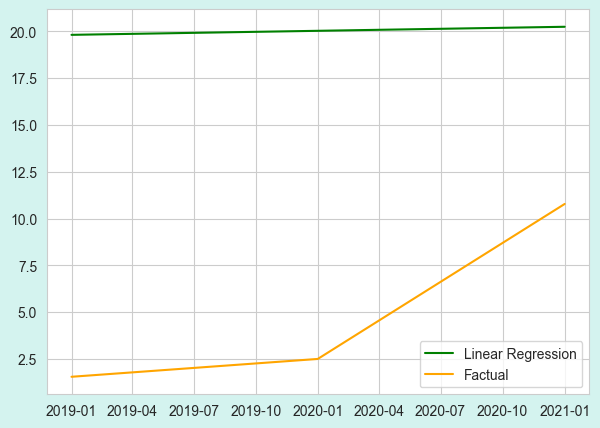

In [31]:
# Построение диаграммы и сравнение результатов
df = pd.DataFrame({'Linear Regression': pd.Series(lr_predict,
            index=y_test.index), 'Fact': y_test}, index=predictions_df.index)

# визуализация прогноза линейной регрессии
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df['Linear Regression'], color = "green", label = "Linear Regression")
ax.plot(df['Fact'], color = "orange", label = "Factual")
ax.legend();

<p style="color: darkgreen; font-size: 2.0em;\">Задание 3.5</p>
  
Сравните результаты и сделайте выводы.

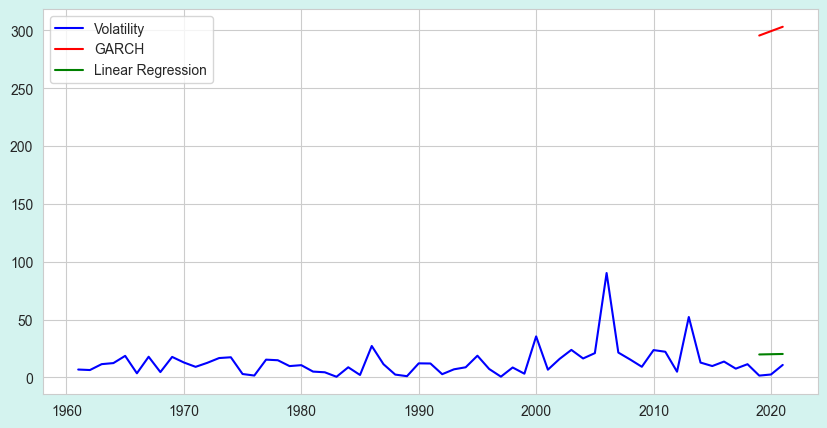

In [32]:
# Построение диаграммы и сравнение результатов
df = pd.DataFrame({'GARCH': predictions_df['Predictions'],
    'Linear Regression': pd.Series(lr_predict, index=y_test.index)},
     index=predictions_df.index)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(InterPol['GDP_vol'], color='blue', label='Volatility')
ax.plot(df['GARCH'], color = "red", label = "GARCH")
ax.plot(df['Linear Regression'], color = "green", label = "Linear Regression")
ax.legend();

Модель GARCH не уловила волатильность и с ней у неё большие расхождения.  
Модель линейной регрессии показала более лучший результат.

<p style="color: darkgreen; font-size: 2.0em;\">Задание 3.6</p>
  
Поченму результаты модели GARCH получились именно такими?  
  
Ещё на диаграмме автокорреляции было видно, что что она практически отсутствует.  
Далее, данные даны по годам и у нас их всего 62. Прогноз краткосрочный.  
Если посмотреть на остатки (диаграмма ниже), то видно, что никакой гетероскедастичности нет.  
Всё это указывает, что в данном случае модель GARCH не рекомендуется применять.

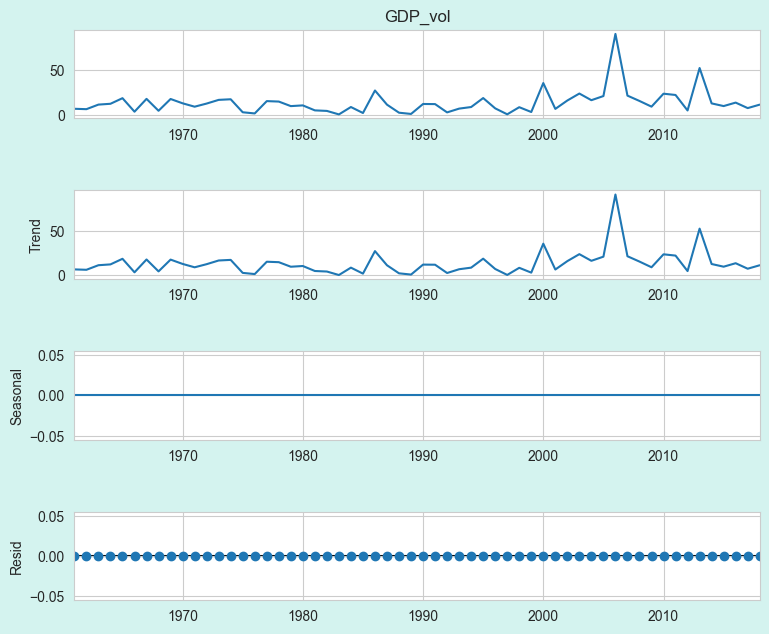

In [33]:
# Визуализация исходного ряда, декомпозиция
result = seasonal_decompose(train_df['GDP_vol'], model='additive')
fig = result.plot()
fig.set_size_inches(7.77, 7)
plt.show();